## Descarga de paqueterías 

In [1]:
# Carga, visualizacion y analisis del modelo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import datetime

# Transformacion
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
# Serie de tiempo agregada
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# Serie de tiempo desagregada
from sklearn.tree import DecisionTreeRegressor


# Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error


c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Lectura de informacion

In [2]:
Ruta_Data = 'C:/Users/jesus/OneDrive/Escritorio/Trabajo/CHEP/Prueba Chep/'
df = pd.read_excel(f'{Ruta_Data}/Caso_de_estudio_datos.xlsx')

## Primeras impresiones de los datos + transformaciones sencillas

In [3]:
df.head()

,Country,Customer,Location,City / Town,Fiscal Week/ Year Delivery,Delivery Qty
0,MX,14392,Loc 1,Queretaro,FW/027/2012,4386
1,MX,14392,Loc 6,Queretaro,FW/027/2012,2193
2,MX,14392,Loc 16,El Marques,FW/027/2012,13155
3,MX,14392,Loc 18,Queretaro,FW/027/2012,2193
4,MX,14392,Loc 1,Queretaro,FW/028/2012,10962


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1835 entries, 0 to 1834
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Country                     1835 non-null   object
 1   Customer                    1835 non-null   int64 
 2   Location                    1835 non-null   object
 3   City / Town                 1835 non-null   object
 4   Fiscal Week/ Year Delivery  1835 non-null   object
 5   Delivery Qty                1835 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 86.1+ KB


In [5]:
print(len(df))
print(len(df['Country'].unique()))
print(len(df['Customer'].unique()))
print(len(df['Location'].unique()))
print(len(df['City / Town'].unique()))
print(len(df['Fiscal Week/ Year Delivery'].unique()))
print(len(df['Delivery Qty'].unique()))

1835
1
1
18
10
494
56


* Derivado de este analisis nos damos cuenta que las variables  Country & Custommer no tiene sentido incluirlas en el analisis, ya que unicamente cuentan con un valor .
Por ellos las eliminiremos del DF

* Ademas debemos de hacer cambios en la columna de la semana fiscal, ya que viene en un formato dificil de ordenar. Buscando un patron

In [6]:
df = df[['Fiscal Week/ Year Delivery','City / Town','Location','Delivery Qty']]

In [7]:
df['Fiscal Week/ Year Delivery'].str[0:2].unique()

array(['FW'], dtype=object)

In [8]:
df['Fiscal Week/ Year Delivery'].str[3:6].unique()

array(['027', '028', '029', '030', '031', '032', '033', '034', '035',
       '036', '037', '038', '039', '040', '041', '042', '043', '044',
       '045', '046', '047', '048', '049', '050', '051', '052', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013', '014', '015', '016', '017', '018', '019',
       '020', '021', '022', '023', '024', '025', '026'], dtype=object)

In [9]:
df['Fiscal Week/ Year Delivery'].str[7:11].unique()

array(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021'], dtype=object)

In [10]:
df['Semana']= df['Fiscal Week/ Year Delivery'].str[3:6]
df['Año']= df['Fiscal Week/ Year Delivery'].str[7:11]
df['Ano_Semana'] = df['Año']  + '_' +df['Semana']
df.sort_values(by=['Ano_Semana'],inplace = True)
S_Tiempo_AGG = pd.pivot_table(df,index='Ano_Semana',values='Delivery Qty',aggfunc='sum')
df.set_index('Ano_Semana', inplace=True)
S_Tiempo_AGG.head()

,Delivery Qty
Ano_Semana,
2012_027,21927
2012_028,39468
2012_029,19731
2012_030,33108
2012_031,26313


In [11]:
# Definimos un dataframe con dummies
df_dummies = pd.get_dummies(df, columns=['Location', 'City / Town'],dummy_na=True,dtype='int64')

Verificamos que no falte ninguna fecha

In [12]:
# df_val = df[['Año','Semana','Delivery Qty']]
# df_val = pd.pivot_table(df_val,index=['Año','Semana'],aggfunc='sum',values='Delivery Qty').reset_index()
# print(len(df_val[df_val['Año']=='2012']['Semana'])+ 26)
# print(len(df_val[df_val['Año']=='2013']['Semana']))
# print(len(df_val[df_val['Año']=='2014']['Semana']))
# print(len(df_val[df_val['Año']=='2015']['Semana']))
# print(len(df_val[df_val['Año']=='2016']['Semana']))
# print(len(df_val[df_val['Año']=='2017']['Semana']))
# print(len(df_val[df_val['Año']=='2018']['Semana']))
# print(len(df_val[df_val['Año']=='2019']['Semana']))
# print(len(df_val[df_val['Año']=='2020']['Semana']))
# print(len(df_val[df_val['Año']=='2021']['Semana']))

Verificamos consistencia de la BD

In [13]:
pd.pivot_table(df[['City / Town','Location']].drop_duplicates(),index='Location', aggfunc='count')

,City / Town
Location,
Loc 1,1
Loc 10,2
Loc 11,1
Loc 12,1
Loc 13,1
Loc 14,1
Loc 15,1
Loc 16,1
Loc 17,1


In [193]:
df[['City / Town','Location']].drop_duplicates()

,City / Town,Location
Ano_Semana,,
2012_027,Queretaro,Loc 1
2012_027,Queretaro,Loc 6
2012_027,El Marques,Loc 16
2012_027,Queretaro,Loc 18
2012_028,Toluca,Loc 4
2012_028,Mexicali,Loc 5
2012_028,El Marques,Loc 7
2012_030,Cuautitlan Izcalli,Loc 8
2012_031,Aguascalientes,Loc 2


Notamos un problema con el local 10

In [14]:
df[['City / Town','Location']].drop_duplicates()[df[['City / Town','Location']].drop_duplicates()['Location']== 'Loc 10']

,City / Town,Location
Ano_Semana,,
2012_051,El Marques,Loc 10
2015_040,Ejido Palo Alto,Loc 10


## Visualizacion de los datos a forecastear

In [15]:
S_Tiempo_AGG.describe()

,Delivery Qty
count,494.000000
mean,31674.443320
std,10229.578193
min,2193.000000
25%,26307.000000
50%,30693.000000
75%,37272.000000
max,84552.000000


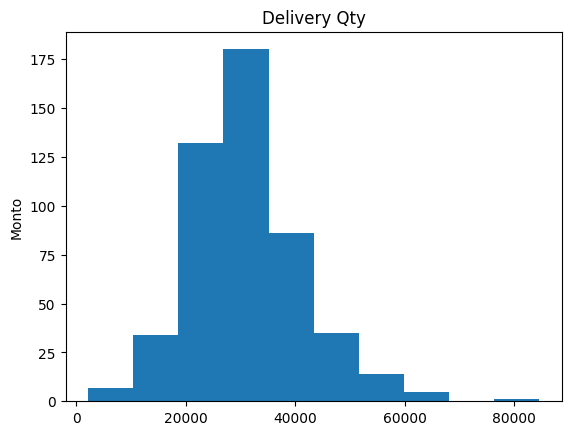

In [16]:
plt.hist(S_Tiempo_AGG['Delivery Qty'])
plt.title('Delivery Qty')
plt.ylabel('Monto')
plt.show()

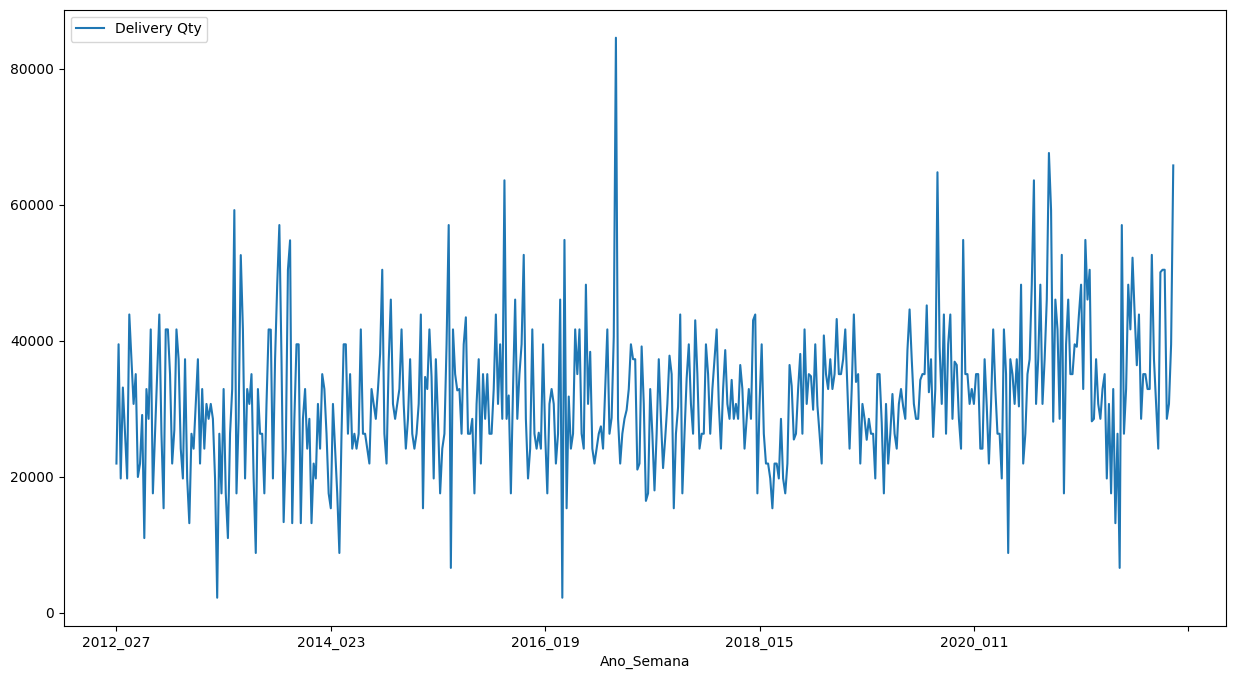

In [17]:
S_Tiempo_AGG.plot(figsize=(15,8))
plt.legend(loc='upper left')
plt.show()

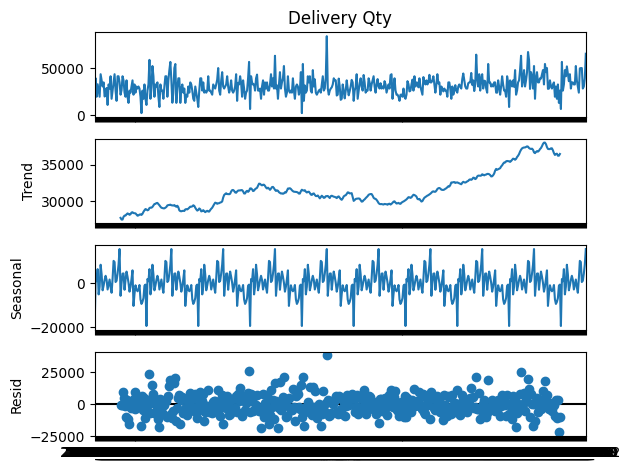

In [18]:
result = seasonal_decompose(S_Tiempo_AGG['Delivery Qty'], model='additive', period=52) 
result.plot()
plt.show()

De esta grafica de descomposiicon notamos que hay tendencia positiva, que hay estacionalidad 

In [19]:
result = adfuller(S_Tiempo_AGG['Delivery Qty'])
print('Estadística ADF:', result[0])
print('Valor p:', result[1])

Estadística ADF: -4.2474843440662795
Valor p: 0.0005470138257874009


Este estadistico nos muestra que no hay estacionalidad

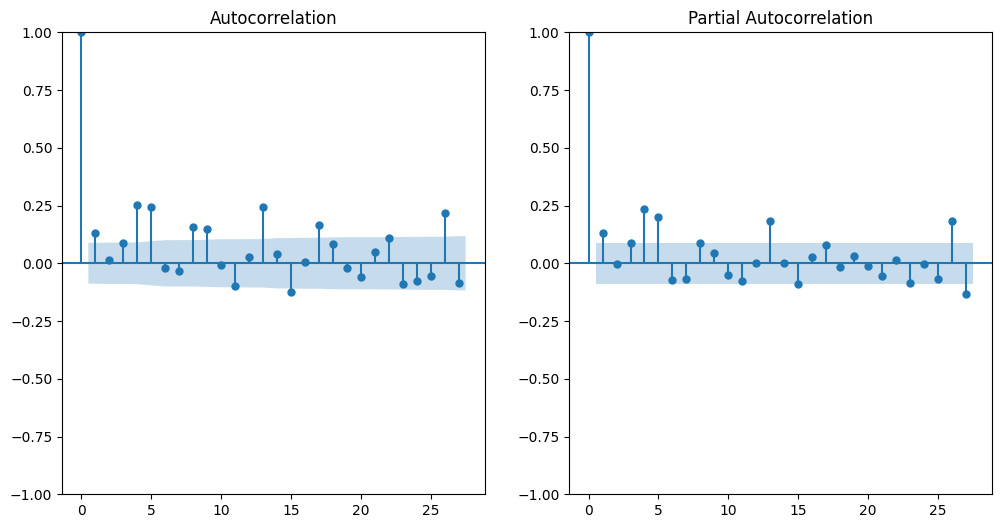

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(S_Tiempo_AGG['Delivery Qty'], ax=plt.gca())
plt.subplot(122)
plot_pacf(S_Tiempo_AGG['Delivery Qty'], ax=plt.gca())
plt.show()

## Importancia de columnas

In [21]:
df_dummies.drop(columns='Fiscal Week/ Year Delivery',inplace = True)
X = df_dummies.drop('Delivery Qty', axis=1)
y = df_dummies['Delivery Qty']
from sklearn.ensemble import RandomForestClassifier
clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)
# Podemos extraer que características son más importantes para la correcta clasificación de los datos
feature_importances = {name: score for name, score in zip(list(X), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
round(100*feature_importances_sorted.head(10),1)

Semana                         68.0
Año                            21.4
City / Town_Pedro Escobedo      0.9
Location_Loc 1                  0.9
Location_Loc 5                  0.8
Location_Loc 2                  0.8
City / Town_El Marques          0.7
City / Town_Mexicali            0.6
City / Town_Ejido Palo Alto     0.6
City / Town_Toluca              0.6
dtype: float64

In [213]:
# Calculamos la correlación total entre X y Y
corrs = abs(X.apply(lambda col: col.corr(y)))

# Ordenamos las correlaciones de mayor a menor
corrs = corrs.sort_values(ascending=False)

# Obtenemos el top 10 de correlaciones
top_10 = corrs.head(10)

# Mostramos los resultados
print(round(100*top_10,1))

Location_Loc 1                 28.6
Año                            26.4
Location_Loc 5                 25.7
City / Town_Mexicali           25.7
City / Town_Ejido Palo Alto    22.0
City / Town_Queretaro          20.1
City / Town_El Marques         19.6
City / Town_Pedro Escobedo     19.4
Location_Loc 11                19.4
City / Town_Aguascalientes     17.8
dtype: float64


In [191]:
# Calculamos la correlación total entre X y Y
corrs = X.apply(lambda col: col.corr(y))

# Ordenamos las correlaciones de mayor a menor
corrs = corrs.sort_values(ascending=False)

# Obtenemos el top 10 de correlaciones
top_10 = corrs.head(5)

# Mostramos los resultados
print(round(100*top_10,1))

Location_Loc 1            28.6
Año                       26.4
City / Town_Queretaro     20.1
City / Town_El Marques    19.6
Location_Loc 10           10.4
dtype: float64


c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [192]:
# Calculamos la correlación total entre X y Y
corrs = X.apply(lambda col: col.corr(y))

# Ordenamos las correlaciones de mayor a menor
corrs = corrs.sort_values(ascending=False)

# Obtenemos el top 10 de correlaciones
top_10 = corrs.tail(5)

# Mostramos los resultados
print(round(100*top_10,1))

City / Town_Ejido Palo Alto   -22.0
City / Town_Mexicali          -25.7
Location_Loc 5                -25.7
Location_nan                    NaN
City / Town_nan                 NaN
dtype: float64


c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Analisis de columna a columna

In [23]:
Ciudad = pd.pivot_table(df,values='Delivery Qty',index='City / Town',aggfunc='mean')
Ciudad['Delivery Qty'] = round(Ciudad['Delivery Qty'],1)
Ciudad.sort_values(by='Delivery Qty',ascending=False)

,Delivery Qty
City / Town,
El Marques,10155.7
Queretaro,9985.2
Toluca,8461.5
Mexicali,2950.7
Pedro Escobedo,2558.5
Ejido Palo Alto,2484.7
Carmen,2293.4
Aguascalientes,2168.7
Tijuana,1926.5


([<matplotlib.patches.Wedge at 0x19c7b63dd10>,
 [Text(-0.9414894403067937, 0.5688564263421838, 'Aguascalientes'),
  Text(-1.0721822221249577, 0.245815545804548, 'Carmen'),
  Text(-1.099876001155475, -0.016516115834000457, 'Cuautitlan Izcalli'),
  Text(-1.0604287647005126, -0.29238815809766483, 'Ejido Palo Alto'),
  Text(-0.4288919804810188, -1.0129420857477833, 'El Marques'),
  Text(0.5598120258748898, -0.9468951872756837, 'Mexicali'),
  Text(0.8796217791630232, -0.6605039936458204, 'Pedro Escobedo'),
  Text(1.0657324472091874, 0.2724231101898601, 'Queretaro'),
  Text(0.499409590412927, 0.9800969651027356, 'Tijuana'),
  Text(-0.2927472037467422, 1.0603297009413928, 'Toluca')],
 [Text(-0.5135396947127965, 0.310285323459373, '4.9%'),
  Text(-0.5848266666136133, 0.1340812068024807, '5.2%'),
  Text(-0.5999323642666226, -0.00900879045490934, '2.4%'),
  Text(-0.5784156898366432, -0.15948444987145352, '5.6%'),
  Text(-0.23394108026237387, -0.5525138649533362, '23.0%'),
  Text(0.30535201411357

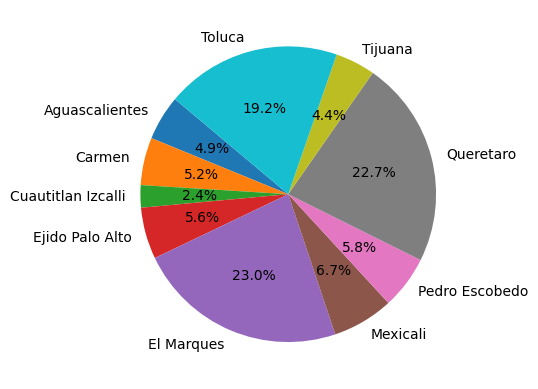

In [200]:
plt.pie(Ciudad['Delivery Qty'], labels=Ciudad.index,autopct='%1.1f%%',
        startangle=140)

In [255]:
df_temp = df[(df['City / Town']== 'Queretaro')| (df['City / Town']== 'El Marques')|(df['City / Town']== 'Toluca')]
Location = pd.pivot_table(df_temp,values='Delivery Qty',index='Location',aggfunc='mean')
Location['Delivery Qty'] = round(Location['Delivery Qty'],1)
Location = Location.sort_values(by='Delivery Qty',ascending=False)
Location

,Delivery Qty
Location,
Loc 1,10925.7
Loc 10,10259.7
Loc 16,10085.3
Loc 14,9651.7
Loc 4,8478.5
Loc 15,8039.0
Loc 18,5790.8
Loc 6,2193.0
Loc 7,2193.0


([<matplotlib.patches.Wedge at 0x19c7b608350>,
 [Text(-1.079281611928498, 0.2124881223810479, 'Loc 1'),
  Text(-0.7801631866779708, -0.7754646363003757, 'Loc 10'),
  Text(0.16395224266087954, -1.0877130421790797, 'Loc 16'),
  Text(0.9593737320166054, -0.5381468594320056, 'Loc 14'),
  Text(1.042518319649364, 0.35093525499081313, 'Loc 4'),
  Text(0.5123766396136107, 0.9733807986488455, 'Loc 15'),
  Text(-0.16775245248763604, 1.0871334392264749, 'Loc 18'),
  Text(-0.5477127850146489, 0.9539448124139557, 'Loc 6'),
  Text(-0.7281469580932171, 0.8245010657480043, 'Loc 7'),
  Text(-0.8253891523382124, 0.7271401152476786, 'Loc 9')],
 [Text(-0.588699061051908, 0.11590261220784429, '16.0%'),
  Text(-0.4255435563698022, -0.42298071070929577, '15.1%'),
  Text(0.08942849599684337, -0.5932980230067707, '14.8%'),
  Text(0.5232947629181484, -0.29353465059927575, '14.2%'),
  Text(0.5686463561723802, 0.19141922999498895, '12.4%'),
  Text(0.27947816706196943, 0.5309349810811884, '11.8%'),
  Text(-0.09150

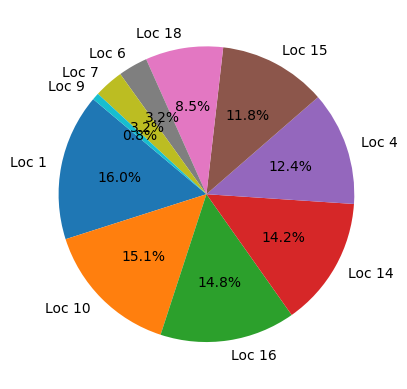

In [201]:
plt.pie(Location['Delivery Qty'], labels=Location.index,autopct='%1.1f%%',
        startangle=140)

In [ ]:
Semana = pd.pivot_table(df,values='Delivery Qty',index='Semana',aggfunc='mean')
Semana['Delivery Qty'] = round(Semana['Delivery Qty'],1)
Semana.sort_values(by='Delivery Qty',ascending=False).head()

,Delivery Qty
Semana,
1,7943.4
2,8096.1
3,9183.8
4,9206.8
5,7517.9


In [217]:
Semana.describe()

,Delivery Qty
count,52.000000
mean,8472.505769
std,1253.263576
min,4234.100000
25%,7925.600000
50%,8354.950000
75%,9224.025000
max,12287.000000


In [207]:
print('Promedio de las primeras 40 semanas',Semana.head(40).mean())
print('Promedio de las ultima 10 semanas',Semana.tail(12).mean())
print('Promedio de las ultima 10 semanas',(Semana.tail(12).mean()-Semana.head(40).mean())/Semana.tail(12).mean())

Promedio de las primeras 40 semanas Delivery Qty    8169.0225
dtype: float64
Promedio de las ultima 10 semanas Delivery Qty    9484.116667
dtype: float64
Promedio de las ultima 10 semanas Delivery Qty    0.138663
dtype: float64


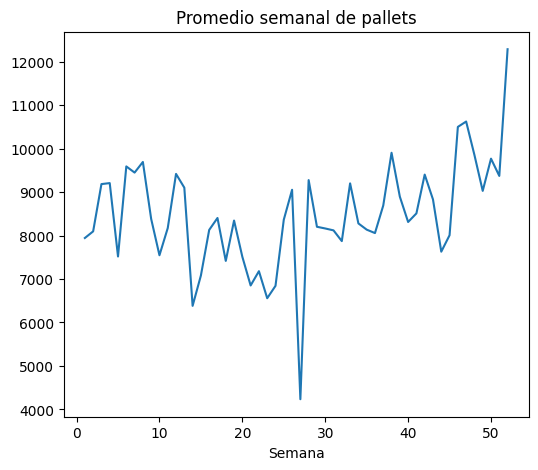

In [210]:
import matplotlib.pyplot as plt
Semana['Delivery Qty'].plot(figsize=(6,5))
plt.legend().set_visible(False)
plt.title('Promedio semanal de pallets')
plt.show()

In [26]:
Año = pd.pivot_table(df,values='Delivery Qty',index='Año',aggfunc='mean')
Año['Delivery Qty'] = round(Año['Delivery Qty'],1)
Año.sort_values(by='Delivery Qty',ascending=False)

,Delivery Qty
Año,
2021,10571.2
2020,10164.1
2019,9929.1
2016,9126.1
2017,8734.6
2018,8604.1
2015,8176.4
2014,7135.3
2013,6666.4


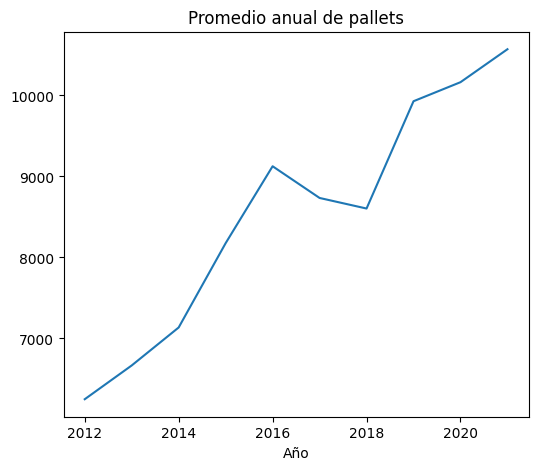

In [211]:
import matplotlib.pyplot as plt
Año['Delivery Qty'].plot(figsize=(6,5))
plt.legend().set_visible(False)
plt.title('Promedio anual de pallets')
plt.show()

## Modelo 1
### Modelo fbprophet para serie de tiempo agregada

* Este modelo nos pide un df muy especifico. Por ello procederemos a hacer cambios en el DF de serie de tiempo agregada
* Los cambios serán semana fiscal por una fecha especifica
* Cambio en el nombre de las columans 

### Generacion de todos los dataframes a utilizar

In [27]:
# Función para convertir número de semana a fecha
def week_to_date(year, week):
    return datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").date()
df_2 = df
df_2['Semana'] = df_2['Semana'].astype('Int64')
# Aplicar la función a la columna del DataFrame
df_2['Fecha'] = df_2.apply(lambda row: week_to_date(row['Año'], row['Semana']), axis=1)
# Creacion del Datframe que nos admite el modeloo
df_grouped = df_2.groupby('Fecha')['Delivery Qty'].sum().reset_index()
df_grouped = df_grouped.rename(columns={'Fecha': 'ds', 'Delivery Qty': 'y'})

In [28]:
temp = df.copy()
temp['Año'] = temp['Año'].astype('int64')
temp = pd.pivot_table(temp,index=['Año','Semana'],values='Delivery Qty',aggfunc='sum').reset_index()
S_T_AGG_Train =temp[temp['Año']<=2020]
S_T_AGG_Test =temp[temp['Año']>2020]

In [29]:
df_dummies_2 = df.copy()
df_dummies_2.drop(columns = ['Location','Fiscal Week/ Year Delivery','Fecha'],inplace = True)
df_dummies_2 = pd.get_dummies(df_dummies_2, columns= ['City / Town'],dtype='int64')
temp = df_dummies_2
temp['Año'] = temp['Año'].astype('int64')
df_dummies_Train =temp[temp['Año']<=2020]
df_dummies_Test =temp[temp['Año']>2020]

In [30]:
temp = df_grouped.copy()
temp['Año'] = temp['ds'].astype(str).str[0:4].astype('int64')
df_prof_Train =temp[temp['Año']<=2020]
df_prof_Test =temp[temp['Año']>2020]
df_prof_Train.drop(columns = 'Año',inplace = True)
df_prof_Test.drop(columns = 'Año',inplace = True)

C:\Users\jesus\AppData\Local\Temp\ipykernel_6616\11155470.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prof_Train.drop(columns = 'Año',inplace = True)
C:\Users\jesus\AppData\Local\Temp\ipykernel_6616\11155470.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prof_Test.drop(columns = 'Año',inplace = True)


In [31]:
temp =  pd.pivot_table(df,index=['Año','Semana'],columns='City / Town',values='Delivery Qty',aggfunc='sum',fill_value=0).reset_index()
temp['Año'] = temp['Año'].astype('int64')
df_M4_Train =temp[temp['Año']<=2020]
df_M4_Train.drop(columns = ['Año','Semana'],inplace = True)
df_M4_Test =temp[temp['Año']>2020]
df_M4_Test.drop(columns = ['Año','Semana'],inplace = True)

C:\Users\jesus\AppData\Local\Temp\ipykernel_6616\3358249845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_M4_Train.drop(columns = ['Año','Semana'],inplace = True)
C:\Users\jesus\AppData\Local\Temp\ipykernel_6616\3358249845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_M4_Test.drop(columns = ['Año','Semana'],inplace = True)


### Modelo Prophet

In [32]:
modelo_PROF = Prophet()
modelo_PROF.fit(df_prof_Train)
future = modelo_PROF.make_future_dataframe(periods=365)
future.tail()

11:50:49 - cmdstanpy - INFO - Chain [1] start processing
11:50:49 - cmdstanpy - INFO - Chain [1] done processing


,ds
802,2021-12-24
803,2021-12-25
804,2021-12-26
805,2021-12-27
806,2021-12-28


In [33]:
FCST_1 = modelo_PROF.predict(future)
FCST_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
797,2021-12-19,43770.554821,31406.157015,54409.705250
798,2021-12-20,44080.601541,32552.789741,56187.975660
799,2021-12-21,44317.893134,32584.281077,55521.131281
800,2021-12-22,44475.912561,32671.294471,56822.944971
801,2021-12-23,44549.948388,32685.051414,55805.124424
802,2021-12-24,44537.190719,33473.115697,55224.534445
803,2021-12-25,44436.779189,32602.612945,55780.791352
804,2021-12-26,44249.802615,33371.762027,56220.687378
805,2021-12-27,43979.251089,31959.908346,55199.307278
806,2021-12-28,43629.922543,32606.409613,55680.131984


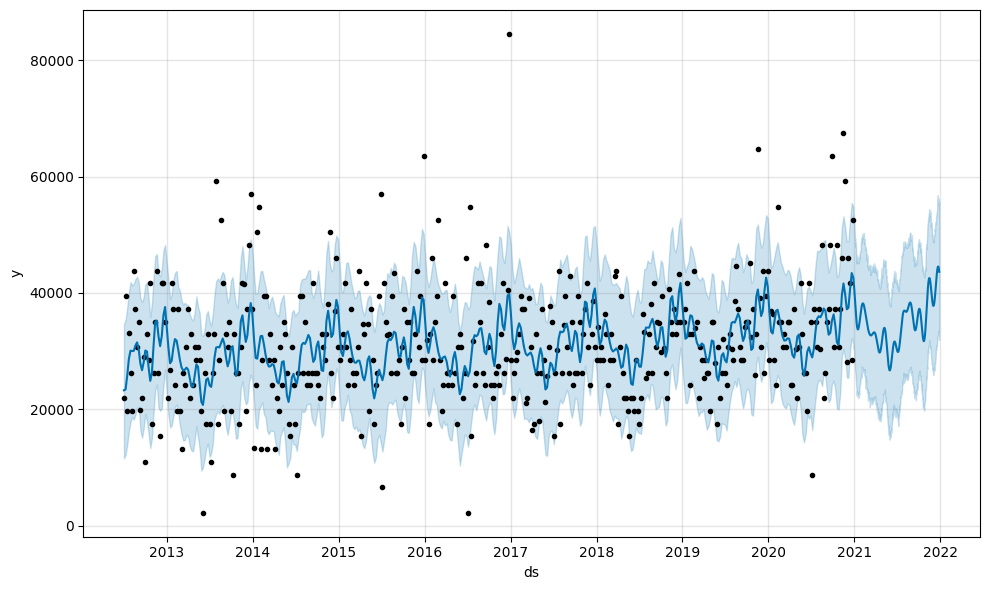

In [34]:
fig1 = modelo_PROF.plot(FCST_1)

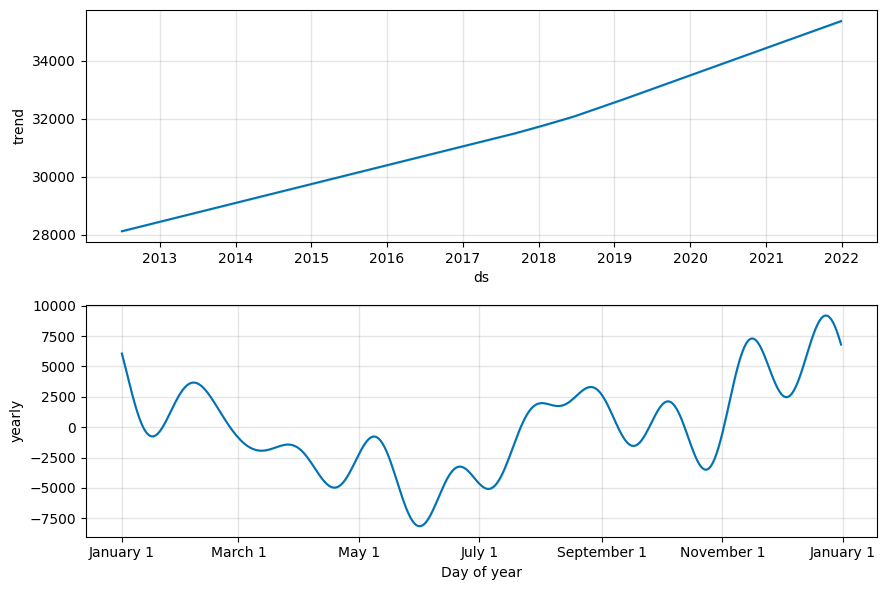

In [35]:
fig2 = modelo_PROF.plot_components(FCST_1)

### Primer tabla para metricas

In [36]:
df_prof_Test ['ds'] =df_prof_Test ['ds'].astype('str')
FCST_1     ['ds'] =FCST_1     ['ds'].astype('str')
Tabla_metricas = df_prof_Test.merge(FCST_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],how='inner',on='ds')
Tabla_metricas.rename(columns={'ds':'Fecha','y':'valor real','yhat':'pronosticado'},inplace=True)

In [37]:
E_M=(Tabla_metricas['valor real']-Tabla_metricas['pronosticado']).mean()
mae = mean_absolute_error(Tabla_metricas['valor real'],Tabla_metricas['pronosticado'])
print('Error Medio:',E_M)
print('Error Medio absoluto:',mae)
print('Error cuadratico medio:',mean_squared_error(Tabla_metricas['valor real'], Tabla_metricas['pronosticado']))

Error Medio: 1704.8225983949164
Error Medio absoluto: 8312.197491967852
Error cuadratico medio: 115780827.0006002


## Modelo 2
### Modelo Holt Winters aditivo

In [38]:
# Probaremos como se desenvuelven los primeros y los ultimos datos de la serie, esto con el objetivo de ver tendencia
print(S_Tiempo_AGG['Delivery Qty'].head(100).mean())
print(S_Tiempo_AGG['Delivery Qty'].tail(100).mean())

28933.71
36223.65


In [74]:
Modelo_HW = ExponentialSmoothing(S_T_AGG_Train['Delivery Qty'],trend='add',seasonal='add',seasonal_periods=52).fit()
FCST_HW = Modelo_HW.forecast(52)
Tabla_metricas['Holt_Winters']= list(FCST_HW)
E_M_H_W = (Tabla_metricas['valor real']-Tabla_metricas['Holt_Winters']).mean()
mae_H_W = mean_absolute_error(Tabla_metricas['valor real'],Tabla_metricas['Holt_Winters'])
print('Error Medio:',E_M_H_W)
print('Error Medio absoluto:',mae_H_W)
print('Error cuadratico medio:',mean_squared_error(Tabla_metricas['valor real'], Tabla_metricas['Holt_Winters']))

Error Medio: -3188.108795848337
Error Medio absoluto: 7748.04430479043
Error cuadratico medio: 99968590.01401731


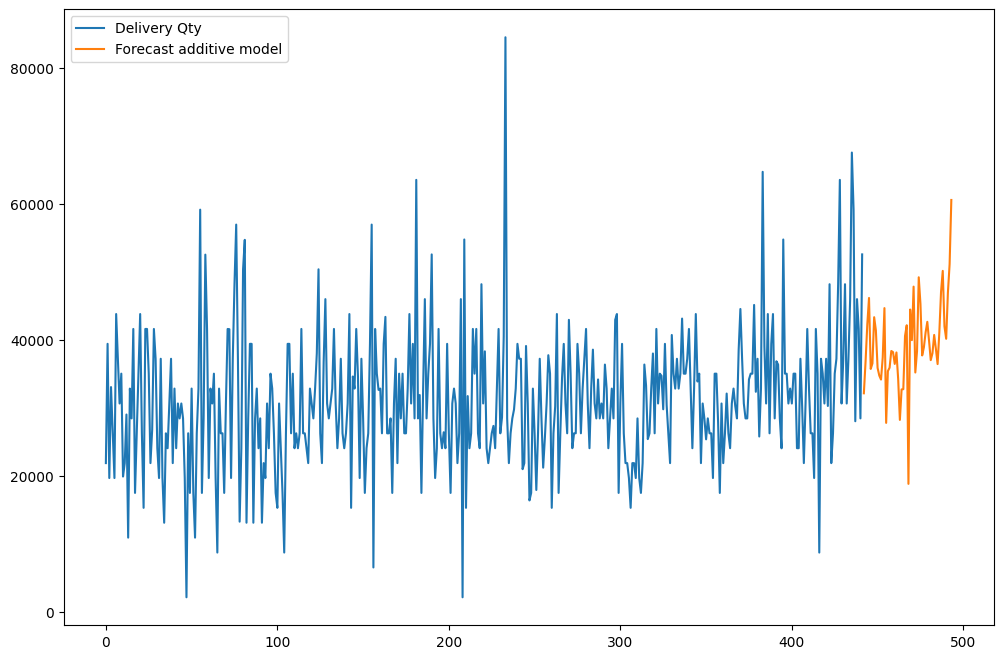

In [41]:
import matplotlib.pyplot as plt
S_T_AGG_Train['Delivery Qty'].plot(figsize=(12,8))
FCST_HW.plot(label='Forecast additive model')
plt.legend(loc='upper left')
plt.show()

### Modelo 3 
Modelo por tienda, Random Forest

### Cambios:
* Usaremos el df de one_hot encoding
* Escalaremos los datos

In [42]:
X_train = df_dummies_Train.drop('Delivery Qty', axis=1)
y_train = df_dummies_Train['Delivery Qty']
X_test = df_dummies_Test.drop('Delivery Qty', axis=1)
y_test = df_dummies_Test['Delivery Qty']

In [43]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [44]:
# Crear el modelo de árbol de decisión
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train_scaled)
# Hacer predicciones
y_pred_scaled = model.predict(X_test)
# Invertir la transformación para tener las predicciones en la escala original
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
print('Error Medio:',(y_test-y_pred).mean())
print('Error Medio absoluto:',mean_absolute_error(y_test,y_pred))
print('Error cuadratico medio:',mean_squared_error(y_test, y_pred))

Error Medio: 600.0166666666667
Error Medio absoluto: 4053.35
Error cuadratico medio: 30472288.15


In [82]:
df_dummies_2 = df.copy()
df_dummies_2.drop(columns = ['Location','Fiscal Week/ Year Delivery','Fecha'],inplace = True)
df_dummies_2['Año'] = df_dummies_2['Año'].astype('int64')
df_dummies_Test =df_dummies_2[df_dummies_2['Año']>2020]
df_dummies_Test['Valor predicho'] = y_pred
Tabla_R_F_R = pd.pivot_table(df_dummies_Test,index=['Año','Semana'],columns='City / Town',values='Valor predicho',aggfunc='sum',fill_value=0).reset_index()
# Metemos manualmente la ciudad de cuautitlan
Tabla_R_F_R['Cuautitlan Izcalli'] =0

C:\Users\jesus\AppData\Local\Temp\ipykernel_6616\2871228892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummies_Test['Valor predicho'] = y_pred


### Modelo 4
Modelo por tienda, Holt winnters

In [47]:
column_dict = {col: f'Ciudad_{idx + 1}' for idx, col in enumerate(df_M4_Train.columns)}
df_M4_Train.rename(columns=column_dict,inplace=True)

C:\Users\jesus\AppData\Local\Temp\ipykernel_6616\2910497857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_M4_Train.rename(columns=column_dict,inplace=True)


In [48]:
for i in range(1,len(column_dict)+1):
    globals()[f'Ciudad_{i}'] = pd.DataFrame(df_M4_Train[f'Ciudad_{i}'])

In [49]:
for i in range(1,len(column_dict)+1):
    globals()[f'model_add_{i}'] = ExponentialSmoothing(globals()[f'Ciudad_{i}'][f'Ciudad_{i}'],trend='add',seasonal='add',seasonal_periods=52).fit()

c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retval

In [50]:
for i in range(1,len(column_dict)+1):
    globals()[f'forecast_add_{i}'] = globals()[f'model_add_{i}'].forecast(52)
    globals()[f'forecast_add_{i}'] = np.maximum(globals()[f'forecast_add_{i}'] , 0)
    

In [51]:
df_FCST_CD_HW = pd.DataFrame()
for i in range(1,len(column_dict)+1):
    df_FCST_CD_HW[list(column_dict.keys())[i-1]] = list(globals()[f'forecast_add_{i}'] )
df_FCST_CD_HW.head()

,Aguascalientes,Carmen,Cuautitlan Izcalli,Ejido Palo Alto,El Marques,Mexicali,Pedro Escobedo,Queretaro,Tijuana,Toluca
0,0.000000,66.676652,0.0,0.000000,6743.494111,181.472574,53.698991,13414.399981,68.142174,10630.746816
1,720.657648,66.830386,0.0,0.000000,10060.481878,582.414842,463.869903,16426.799920,68.594495,8598.930192
2,0.000000,66.984077,0.0,132.304789,12266.731494,989.106623,47.833633,16246.902576,68.899733,13326.067144
3,398.234355,67.137726,0.0,0.000000,13953.315328,2240.567740,868.285439,14530.865846,68.949020,14802.644114
4,0.000000,67.291333,0.0,1216.889934,9049.762960,1681.885770,63.153964,13255.617524,617.249408,10269.946384


Creamos un dataframe con cada una de las columnas / ciudades para comprobar tabla por tabla sus metricas

In [122]:
temp = df_M4_Test.copy()
column_dict = {col: f'Ciudad_{idx + 1}' for idx, col in enumerate(temp.columns)}
temp.rename(columns=column_dict,inplace=True)
for i in range(1,len(column_dict)+1):
    globals()[f'Ciudad_{i}'] = pd.DataFrame(temp[f'Ciudad_{i}'])
    globals()[f'Ciudad_{i}'].rename(columns = {f'Ciudad_{i}':list(column_dict.keys())[i-1]}, inplace = True)
    globals()[f'Ciudad_{i}']['RFR_FCST'] = list(Tabla_R_F_R[f'{list(column_dict.keys())[i-1]}'])
    globals()[f'Ciudad_{i}']['H_W_FCST'] = list(df_FCST_CD_HW[f'{list(column_dict.keys())[i-1]}'])

### Metricas de error para modelo de ciudades

In [130]:
resultados = {
    'Ciudad': [],
    'Modelo': [],
    'Mean Absolute Error': [],
    'Mean Squared Error': [],
    'Error Medio': []
}
Tabla_Errores_Comp = pd.DataFrame()
for i in range(1,len(column_dict)+1):
    mae_modelo1 = mean_absolute_error(globals()[f'Ciudad_{i}'][list(column_dict.keys())[i-1]], globals()[f'Ciudad_{i}']['RFR_FCST'])
    mse_modelo1 = mean_squared_error(globals()[f'Ciudad_{i}'][list(column_dict.keys())[i-1]], globals()[f'Ciudad_{i}']['RFR_FCST'])
    E_M_modelo1 = (globals()[f'Ciudad_{i}'][list(column_dict.keys())[i-1]]- globals()[f'Ciudad_{i}']['RFR_FCST']).mean()
    resultados['Ciudad'].append(list(column_dict.keys())[i-1])
    resultados['Modelo'].append('RFR_FCST')
    resultados['Mean Absolute Error'].append(mae_modelo1)
    resultados['Mean Squared Error'].append(mse_modelo1)
    resultados['Error Medio'].append(E_M_modelo1)
# Modelo 2
    mae_modelo2 = mean_absolute_error(globals()[f'Ciudad_{i}'][list(column_dict.keys())[i-1]], globals()[f'Ciudad_{i}']['H_W_FCST'])
    mse_modelo2 = mean_squared_error(globals()[f'Ciudad_{i}'][list(column_dict.keys())[i-1]], globals()[f'Ciudad_{i}']['H_W_FCST'])
    E_M_modelo2 = (globals()[f'Ciudad_{i}'][list(column_dict.keys())[i-1]]- globals()[f'Ciudad_{i}']['H_W_FCST']).mean()
    resultados['Ciudad'].append(list(column_dict.keys())[i-1])
    resultados['Modelo'].append('H_W_FCST')
    resultados['Mean Absolute Error'].append(mae_modelo2)
    resultados['Mean Squared Error'].append(mse_modelo2)
    resultados['Error Medio'].append(E_M_modelo2)

In [218]:
tabla_resultados = pd.DataFrame(resultados)
round(pd.pivot_table(tabla_resultados,index='Modelo',values= ['Mean Absolute Error','Mean Squared Error','Error Medio'],aggfunc='mean'),1)

,Error Medio,Mean Absolute Error,Mean Squared Error
Modelo,,,
H_W_FCST,-303.6,1393.1,7389086.8
RFR_FCST,207.7,1403.1,10548099.7


<!-- # FORECAST DATOS 1 -->

# Forecast Modelo sencillo

In [139]:
df_champ_C = df.copy()
df_champ_C['Año'] = df_champ_C['Año'].astype('int64')
df_champ_C = pd.pivot_table(df_champ_C,index=['Año','Semana'],values='Delivery Qty',aggfunc='sum').reset_index()

In [225]:
df_champ_C_2021 = df_champ_C[(df_champ_C['Año'] == 2021)& (df_champ_C['Semana'] <= 5)]
df_champ_C_2020 = df_champ_C[(df_champ_C['Año'] == 2020)& (df_champ_C['Semana'] <= 5)]

In [149]:
Tabla_Forecast = pd.DataFrame()
Modelo_HW = ExponentialSmoothing(df_champ_C['Delivery Qty'],trend='add',seasonal='add',seasonal_periods=52).fit()
periodos = 5
FCST_HW = Modelo_HW.forecast(periodos)
Tabla_Forecast['FCST_CLIENTE'] = list(FCST_HW)
# Calcular el error estándar para las bandas de confianza
# La desviación estándar de los errores residuales
residuals = df_champ_C['Delivery Qty'] - Modelo_HW.fittedvalues
std_error = np.std(residuals)

# Calcular los límites de bandas de confianza al 95%
alpha = 0.05
z = 1.96  # Valor crítico para un intervalo de confianza del 95%
upper_bound = FCST_HW + z * std_error
lower_bound = FCST_HW - z * std_error

Tabla_Forecast['FCST_CLIENTE_Banda_Sup'] = list(upper_bound)
Tabla_Forecast['FCST_CLIENTE_Banda_inf'] = list(lower_bound)
Tabla_Forecast

c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,FCST_CLIENTE,FCST_CLIENTE_Banda_Sup,FCST_CLIENTE_Banda_inf
0,30880.388272,47901.460191,13859.316352
1,36761.749053,53782.820973,19740.677133
2,42214.254353,59235.326273,25193.182433
3,45040.456101,62061.528020,28019.384181
4,35310.215296,52331.287215,18289.143376


In [226]:
Tabla_Forecast.to_excel(f'{Ruta_Data}/Forecast_2022.xlsx',index=False)
df_champ_C_2020.to_excel(f'{Ruta_Data}/Campeon_2020.xlsx',index=False)
df_champ_C_2021.to_excel(f'{Ruta_Data}/Campeon_2021.xlsx',index=False)

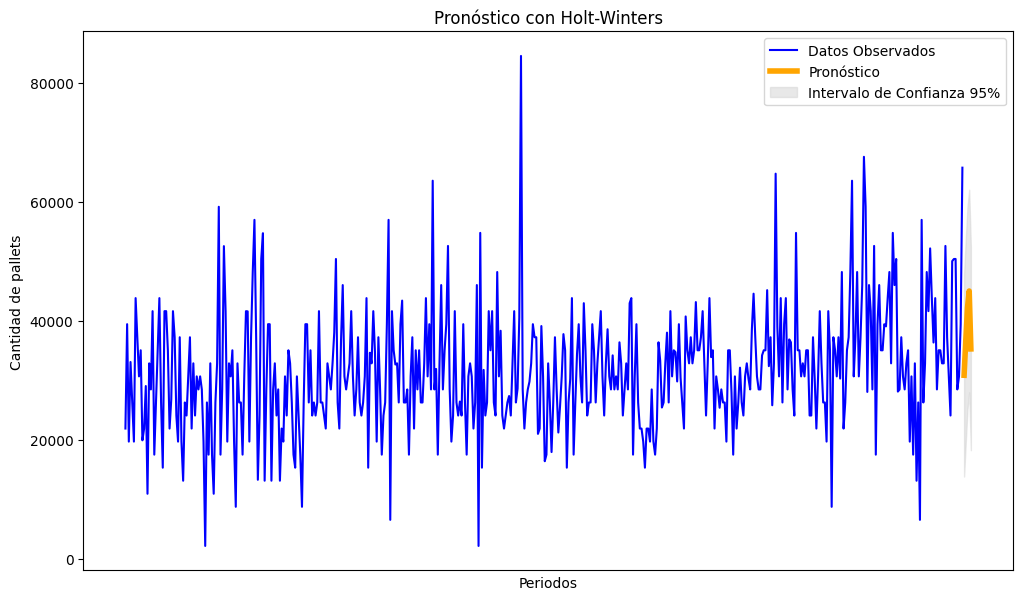

In [221]:
# Graficar los resultados
plt.figure(figsize=(12, 7))
plt.plot(df_champ_C['Delivery Qty'], label='Datos Observados', color='blue')
plt.plot(FCST_HW.index, FCST_HW, label='Pronóstico', color='orange', linewidth=4)
plt.fill_between(FCST_HW.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='Intervalo de Confianza 95%')
plt.title('Pronóstico con Holt-Winters')
plt.xlabel('Periodos')
plt.ylabel('Cantidad de pallets')
plt.legend()
plt.xticks([])
plt.show()

In [250]:
Tabla_Forecast

,FCST_CLIENTE,FCST_CLIENTE_Banda_Sup,FCST_CLIENTE_Banda_inf
0,30880.388272,47901.460191,13859.316352
1,36761.749053,53782.820973,19740.677133
2,42214.254353,59235.326273,25193.182433
3,45040.456101,62061.528020,28019.384181
4,35310.215296,52331.287215,18289.143376


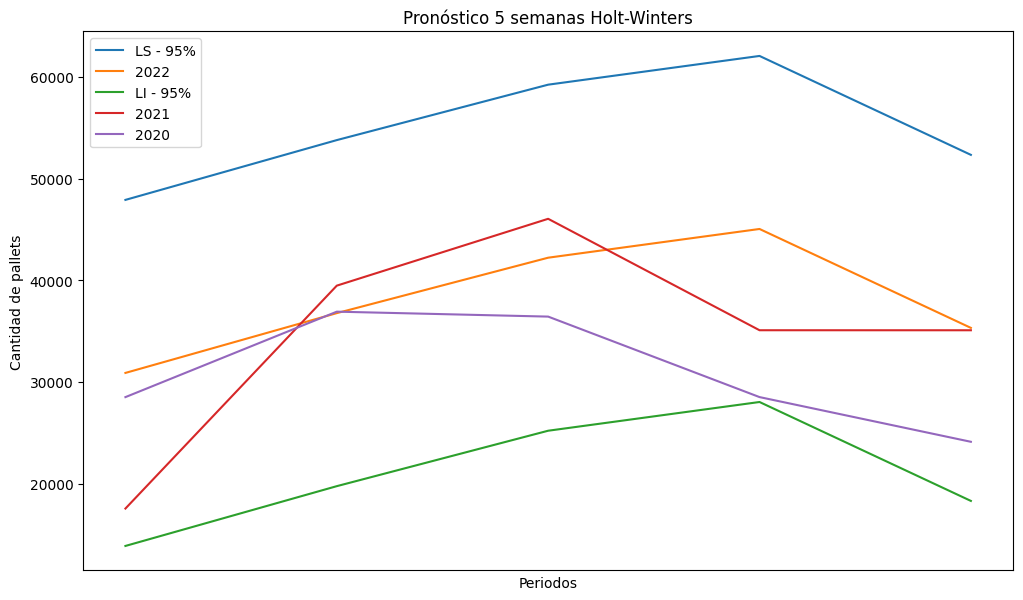

In [254]:
# Graficar los resultados
plt.figure(figsize=(12, 7))
plt.plot(Tabla_Forecast['FCST_CLIENTE_Banda_Sup'], label='LS - 95%')
plt.plot(Tabla_Forecast['FCST_CLIENTE'], label='2022')
plt.plot(Tabla_Forecast['FCST_CLIENTE_Banda_inf'], label='LI - 95%')
plt.plot(df_champ_C_2021.reset_index()['Delivery Qty'], label='2021')
plt.plot(df_champ_C_2020.reset_index()['Delivery Qty'], label='2020')
plt.title('Pronóstico 5 semanas Holt-Winters')
plt.xlabel('Periodos')
plt.ylabel('Cantidad de pallets')
plt.legend()
plt.xticks([])
plt.show()

# Forecast Modelo ciudades

In [233]:
df_ciudades_C_2021 = temp[(temp['Año'] == 2021)& (temp['Semana'] <= 5)]
df_ciudades_C_2020 = temp[(temp['Año'] == 2020)& (temp['Semana'] <= 5)]

In [239]:
##################### Tabla ############################
temp =  pd.pivot_table(df,index=['Año','Semana'],columns='City / Town',values='Delivery Qty',aggfunc='sum',fill_value=0).reset_index()
temp['Año'] = temp['Año'].astype('int64')
temp =temp[temp['Año']>2019]
df_M4 = temp.drop(columns = ['Año','Semana'])
##################### Modelo ############################

column_dict = {col: f'Ciudad_{idx + 1}' for idx, col in enumerate(df_M4.columns)}
df_M4.rename(columns=column_dict,inplace=True)
for i in range(1,len(column_dict)+1):
    globals()[f'Ciudad_{i}'] = pd.DataFrame(df_M4[f'Ciudad_{i}'])
for i in range(1,len(column_dict)+1):
    globals()[f'model_add_{i}'] = ExponentialSmoothing(globals()[f'Ciudad_{i}'][f'Ciudad_{i}'],trend='add',seasonal='add',seasonal_periods=52).fit()
for i in range(1,len(column_dict)+1):
    globals()[f'forecast_add_{i}'] = globals()[f'model_add_{i}'].forecast(5)
    globals()[f'forecast_add_{i}'] = np.maximum(globals()[f'forecast_add_{i}'] , 0)
df_FCST_CD_HW = pd.DataFrame()
for i in range(1,len(column_dict)+1):
    df_FCST_CD_HW[list(column_dict.keys())[i-1]] = list(globals()[f'forecast_add_{i}'] )
df_FCST_CD_HW.head()

c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\ba

,Aguascalientes,Carmen,Cuautitlan Izcalli,Ejido Palo Alto,El Marques,Mexicali,Pedro Escobedo,Queretaro,Tijuana,Toluca
0,551.587982,19.912146,0.0,0.0,2612.187589,251.994882,63.827133,9830.762937,0.000000,6762.826966
1,0.000000,20.947309,0.0,0.0,13511.943933,274.480904,33.248830,16474.276677,379.818842,10979.793678
2,0.000000,22.031279,0.0,0.0,11279.322692,4703.113591,11.725197,20795.563914,2.203278,10957.648699
3,0.000000,23.088904,0.0,0.0,13495.726894,340.549894,0.000000,11923.352232,5.522825,11103.887806
4,0.000000,24.121126,0.0,0.0,6918.170885,342.421845,0.000000,18479.764741,8.868153,11019.159301


In [237]:
df_ciudades_C_2020.to_excel(f'{Ruta_Data}/Forecast_2020_CIUDAD.xlsx',index=False)
df_ciudades_C_2021.to_excel(f'{Ruta_Data}/Forecast_2021_CIUDAD.xlsx',index=False)
df_FCST_CD_HW.to_excel(f'{Ruta_Data}/Forecast_2022_CIUDAD.xlsx',index=False)